# Downstream Training 

## Load Ground Truth

In [1]:
import csv
from tqdm import tqdm

label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]


Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3809395.69it/s]


## Import Sound Model from Huggingface

### Wav2vec
Huggingface: https://huggingface.co/facebook/wav2vec2-base-960h

In [2]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [3]:
from transformers import AutoProcessor, Wav2Vec2Model, Wav2Vec2Config
import torch

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

Test Model


In [ ]:
!pip install librosa


### Whisper
Huggingface: https://huggingface.co/openai/whisper-small

In [6]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="openai/whisper-small")

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\10857\.cache\huggingface\hub\models--openai--whisper-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will 

In [7]:
import torch
from transformers import WhisperProcessor, WhisperModel

processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperModel.from_pretrained("openai/whisper-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

WhisperModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  

## Generating Embeddings

In [5]:
import os
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa

def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_root = "../ComParE2017_Cold_4students/wav/"
output_root = "embeddings_lhl_origin/"
data_dir = ""

config    = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h",
                                           output_hidden_states=True)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h", config= config).to(device).eval()

for split in ["train_files", "devel_files"]:
    input_dir = os.path.join(input_root, split, data_dir)
    output_dir = os.path.join(output_root, split)
    os.makedirs(output_dir, exist_ok=True)

    
    wav_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]
    print(f"[{split}] Found {len(wav_files)} wav files")

    cold_files = []
    for filename in wav_files:
        file_id = filename[:-4]  # 去掉.wav扩展名
        label = search_in_ground_truth(file_id, label_dict)
        if label == "C":
            cold_files.append(filename)

    for filename in tqdm(cold_files, desc=f"Processing {split} Cold files"):
        wav_path = os.path.join(input_dir, filename)

        waveform, sr = librosa.load(wav_path, sr=16000)

        inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            out = model(**inputs)
            hs = out.hidden_states  

        first_k = hs[0:2]  # 修改为前三层 (第0, 1层)
        pooled = []
        for layer in first_k:
            # layer: [1, T, 768]
            m = layer.mean(dim=1)   # [1,768]
            #s = layer.std(dim=1)    # [1,768]
            mx= layer.max(dim=1).values  # [1,768]
            #mn = layer.min(dim=1).values
            pooled.append(m)
            #pooled.append(s)
            pooled.append(mx)
            #pooled.append(mn)

        feat = torch.cat(pooled, dim=-1)  
        np_feat = feat.cpu().numpy().squeeze()

        save_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))
        np.save(save_path, np_feat)


Using device: cuda


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[train_files] Found 9505 wav files


Processing train_files Cold files: 100%|██████████| 970/970 [00:21<00:00, 44.59it/s]


[devel_files] Found 9596 wav files


Processing devel_files Cold files: 100%|██████████| 1011/1011 [00:19<00:00, 51.69it/s]


In [ ]:
import os
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
import librosa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_root = "../ComParE2017_Cold_4students/wav/"
output_root = "embeddings_lhl/"
data_dir = "processed_files"

config    = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h",
                                           output_hidden_states=True)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h", config= config).to(device).eval()

for split in ["train_files", "devel_files", "test_files"]:
    input_dir = os.path.join(input_root, split, data_dir)
    output_dir = os.path.join(output_root, split)
    os.makedirs(output_dir, exist_ok=True)

    wav_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]
    print(f"[{split}] Found {len(wav_files)} wav files")

    for filename in tqdm(wav_files, desc=f"Processing {split}"):
        wav_path = os.path.join(input_dir, filename)

        waveform, sr = librosa.load(wav_path, sr=16000)

        inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            out = model(**inputs)
            
        last_layer = out.last_hidden_state 

        m = last_layer.mean(dim=1)  
        mx = last_layer.max(dim=1).values 

        feat = torch.cat([m, mx], dim=-1)

        np_feat = feat.cpu().numpy().squeeze()

        save_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))
        np.save(save_path, np_feat)

Using device: cuda


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[train_files] Found 9505 wav files


Processing train_files: 100%|██████████| 9505/9505 [03:51<00:00, 41.03it/s]


[devel_files] Found 9596 wav files


Processing devel_files: 100%|██████████| 9596/9596 [03:55<00:00, 40.80it/s]


[test_files] Found 9551 wav files


Processing test_files: 100%|██████████| 9551/9551 [03:52<00:00, 41.01it/s]


In [10]:
# Print one example
import numpy as np
example_file = "../embeddings_lhl/train_files/train_9502.npy"
embedding = np.load(example_file)
print(f"Embedding shape for {example_file}: {embedding.shape}")
# Print itself
print(f"Embedding for {example_file}: {embedding}")

Embedding shape for ../embeddings_lhl/train_files/train_9502.npy: (1536,)
Embedding for ../embeddings_lhl/train_files/train_9502.npy: [-0.04937948  0.00597529 -0.10174674 ...  0.43990773  0.25279623
  0.341296  ]


In [11]:
config    = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h",
                                           output_hidden_states=True)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h", config= config).to(device).eval()

out = model(**inputs)
hs = out.hidden_states 
len(hs)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


13

## Load Embeddings

In [27]:
from concurrent.futures import ThreadPoolExecutor
import glob


def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

In [ ]:
import os
import numpy as np
from tqdm import tqdm
embedding_dir = "./embeddings_lhl/"
embedding_dir_add = "./embeddings_lhl_origin/"
val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
test_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
train_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "train_files"))
train_embeddings_dict_additional = load_acoustic_embeddings(os.path.join(embedding_dir_add, "train_files"))


Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:00<00:00, 33611.46it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:01<00:00, 6653.36it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9505/9505 [00:01<00:00, 6330.19it/s]


✅ Loaded 9505 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 970/970 [00:00<00:00, 7347.54it/s]

✅ Loaded 970 embeddings.
🧪 Sample shape: (3072,)


In [23]:
def combine_embeddings_as_list(original_dict, additional_dict):
    """将embedding合并为列表形式，一个key对应多个embedding"""
    combined_dict = {}
    
    # 首先处理原始embedding
    for key, embedding in original_dict.items():
        combined_dict[key] = [embedding]  # 转换为列表
    
    # 然后添加额外的embedding
    for key, embedding in additional_dict.items():
        if key in combined_dict:
            combined_dict[key].append(embedding)  # 添加到现有列表
        else:
            combined_dict[key] = [embedding]  # 创建新列表
    
    return combined_dict

# 使用
train_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "train_files"))
train_embeddings_dict_additional = load_acoustic_embeddings(os.path.join(embedding_dir_add, "train_files"))

# 合并为列表形式
train_embeddings_dict = combine_embeddings_as_list(train_embeddings_dict, train_embeddings_dict_additional)

# 现在每个key对应一个embedding列表
print("📊 Combined embedding statistics:")
for key, embeddings in train_embeddings_dict.items():
    print(f"  {key}: {len(embeddings)} embeddings, shapes: {[emb.shape for emb in embeddings]}")

Loading acoustic embeddings: 100%|██████████| 9505/9505 [00:01<00:00, 6717.16it/s]


✅ Loaded 9505 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 970/970 [00:00<00:00, 7362.14it/s]

✅ Loaded 970 embeddings.
🧪 Sample shape: (3072,)
📊 Combined embedding statistics:
  train_0001: 2 embeddings, shapes: [(3072,), (3072,)]
  train_0002: 1 embeddings, shapes: [(3072,)]
  train_0003: 1 embeddings, shapes: [(3072,)]
  train_0004: 2 embeddings, shapes: [(3072,), (3072,)]
  train_0005: 1 embeddings, shapes: [(3072,)]
  train_0006: 1 embeddings, shapes: [(3072,)]
  train_0007: 1 embeddings, shapes: [(3072,)]
  train_0008: 2 embeddings, shapes: [(3072,), (3072,)]
  train_0009: 1 embeddings, shapes: [(3072,)]
  train_0010: 1 embeddings, shapes: [(3072,)]
  train_0011: 1 embeddings, shapes: [(3072,)]
  train_0012: 1 embeddings, shapes: [(3072,)]
  train_0013: 1 embeddings, shapes: [(3072,)]
  train_0014: 2 embeddings, shapes: [(3072,), (3072,)]
  train_0015: 1 embeddings, shapes: [(3072,)]
  train_0016: 1 embeddings, shapes: [(3072,)]
  train_0017: 1 embeddings, shapes: [(3072,)]
  train_0018: 1 embeddings, shapes: [(3072,)]
  train_0019: 1 embeddings, shapes: [(3072,)]
  train_

## test

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

keys = list(train_embeddings_dict.keys())
X_all = np.stack([train_embeddings_dict[k] for k in keys], axis=0)

X, y = [], []
raw_labels = []  

for k, vec in zip(keys, X_all):
    wav = f"{k}.wav"
    if wav in label_dict:
        raw_label = label_dict[wav]
        numeric_label = 1 if raw_label == "C" else 0  # C=Cold=1, 其他=Healthy=0
        
        X.append(vec)
        y.append(numeric_label)
        raw_labels.append(raw_label)

X = np.stack(X, axis=0) 
y = np.array(y)          


In [10]:
print("\n🔄 Analysis Embeddings")

# PCA → 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"PCA: {pca.explained_variance_ratio_}")

pca50 = PCA(n_components=50, random_state=42)
X50 = pca50.fit_transform(X)

print(f"t-SNE input dimension : {X50.shape}")
tsne = TSNE(n_components=2, 
           init="pca", 
           learning_rate="auto", 
           random_state=42,
           perplexity=min(30, len(X)//4),  
           max_iter=1000)
X_tsne = tsne.fit_transform(X50)


🔄 Analysis Embeddings
PCA: [0.10037804 0.07231401]
t-SNE input dimension : (9505, 50)


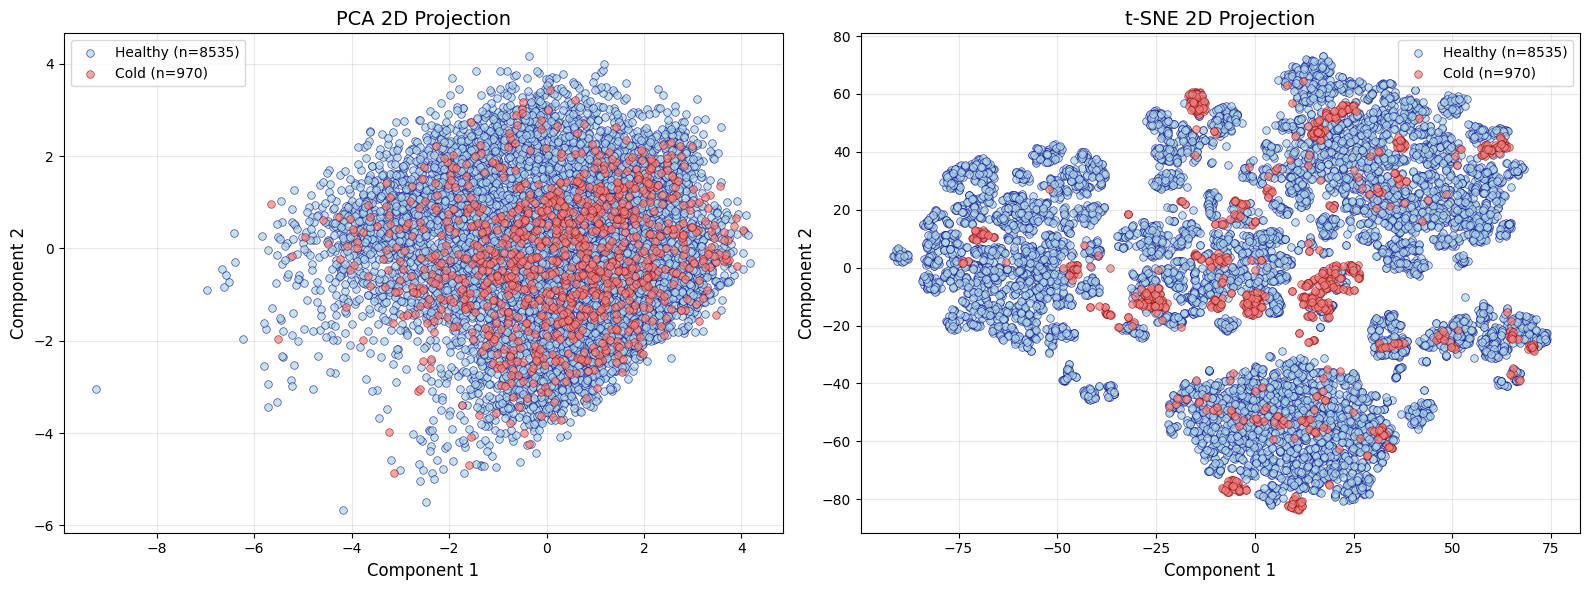

In [13]:
def plot_2d_enhanced(X2d, y, title, ax=None):
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    
    unique_labels = np.unique(y)
    
    if not np.issubdtype(y.dtype, np.number):
        y_numeric = np.array([1 if label == "C" else 0 for label in y])
        y = y_numeric
    
    healthy_mask = (y == 0)
    cold_mask = (y == 1)
    
    if healthy_mask.sum() > 0:
        ax.scatter(X2d[healthy_mask, 0], X2d[healthy_mask, 1],
                  c="lightblue", label=f"Healthy (n={healthy_mask.sum()})", 
                  s=30, alpha=0.7, edgecolors='darkblue', linewidth=0.5)
    
    if cold_mask.sum() > 0:
        ax.scatter(X2d[cold_mask, 0], X2d[cold_mask, 1],
                  c="lightcoral", label=f"Cold (n={cold_mask.sum()})", 
                  s=30, alpha=0.7, edgecolors='darkred', linewidth=0.5)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Component 1", fontsize=12)
    ax.set_ylabel("Component 2", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_2d_enhanced(X_pca, y, "PCA 2D Projection", axes[0])

plot_2d_enhanced(X_tsne, y, "t-SNE 2D Projection", axes[1])

plt.tight_layout()
plt.show()

In [12]:
# 5. 量化分离度分析
def calculate_separability_metrics(embeddings_2d, labels):
    """计算类别间的分离度指标"""
    healthy_points = embeddings_2d[labels == 0]
    cold_points = embeddings_2d[labels == 1]
    
    if len(healthy_points) == 0 or len(cold_points) == 0:
        print("⚠️ 警告: 某个类别没有样本")
        return None
    
    # 计算类内距离(越小越好)
    healthy_center = healthy_points.mean(axis=0)
    cold_center = cold_points.mean(axis=0)
    
    healthy_intra_dist = np.mean(np.linalg.norm(healthy_points - healthy_center, axis=1))
    cold_intra_dist = np.mean(np.linalg.norm(cold_points - cold_center, axis=1))
    avg_intra_dist = (healthy_intra_dist + cold_intra_dist) / 2
    
    # 计算类间距离(越大越好)
    inter_dist = np.linalg.norm(healthy_center - cold_center)
    
    # 分离度比例 (越大越好)
    separability_ratio = inter_dist / avg_intra_dist if avg_intra_dist > 0 else 0
    
    return {
        'inter_class_distance': inter_dist,
        'avg_intra_class_distance': avg_intra_dist,
        'separability_ratio': separability_ratio,
        'healthy_center': healthy_center,
        'cold_center': cold_center,
        'healthy_samples': len(healthy_points),
        'cold_samples': len(cold_points)
    }

# 计算PCA和t-SNE的分离度
print("\n📊 类别分离度分析:")
print("="*50)

pca_metrics = calculate_separability_metrics(X_pca, y)
if pca_metrics:
    print("PCA结果:")
    print(f"   样本分布: Healthy={pca_metrics['healthy_samples']}, Cold={pca_metrics['cold_samples']}")
    print(f"   类间距离: {pca_metrics['inter_class_distance']:.3f}")
    print(f"   平均类内距离: {pca_metrics['avg_intra_class_distance']:.3f}")
    print(f"   分离度比例: {pca_metrics['separability_ratio']:.3f}")

tsne_metrics = calculate_separability_metrics(X_tsne, y)
if tsne_metrics:
    print("\nt-SNE结果:")
    print(f"   样本分布: Healthy={tsne_metrics['healthy_samples']}, Cold={tsne_metrics['cold_samples']}")
    print(f"   类间距离: {tsne_metrics['inter_class_distance']:.3f}")
    print(f"   平均类内距离: {tsne_metrics['avg_intra_class_distance']:.3f}")
    print(f"   分离度比例: {tsne_metrics['separability_ratio']:.3f}")

# 🎯 可分性评估
print("\n🎯 可分性评估:")
for method, metrics in [("PCA", pca_metrics), ("t-SNE", tsne_metrics)]:
    if metrics:
        ratio = metrics['separability_ratio']
        if ratio > 1.5:
            print(f"✅ {method}: 类别具有良好的可分性 (比例={ratio:.3f})")
        elif ratio > 1.0:
            print(f"⚠️ {method}: 类别具有中等可分性 (比例={ratio:.3f})")
        else:
            print(f"❌ {method}: 类别可分性较差 (比例={ratio:.3f})")

# 💡 结论
if pca_metrics and tsne_metrics:
    max_ratio = max(pca_metrics['separability_ratio'], tsne_metrics['separability_ratio'])
    print(f"\n💡 总体结论:")
    if max_ratio < 1.2:
        print("❌ Cold/Healthy embedding 可分性较差，建议:")
        print("   • 尝试其他预训练模型")
        print("   • 使用更复杂的特征提取")
        print("   • 增加数据增强")
    elif max_ratio > 1.5:
        print("✅ Cold/Healthy embedding 具有一定可分性")
        print("   • 可以继续优化分类器")
    else:
        print("⚠️ Cold/Healthy embedding 可分性中等")
        print("   • 需要进一步特征工程")


📊 类别分离度分析:
PCA结果:
   样本分布: Healthy=8535, Cold=970
   类间距离: 0.344
   平均类内距离: 2.091
   分离度比例: 0.165

t-SNE结果:
   样本分布: Healthy=8535, Cold=970
   类间距离: 7.550
   平均类内距离: 47.540
   分离度比例: 0.159

🎯 可分性评估:
❌ PCA: 类别可分性较差 (比例=0.165)
❌ t-SNE: 类别可分性较差 (比例=0.159)

💡 总体结论:
❌ Cold/Healthy embedding 可分性较差，建议:
   • 尝试其他预训练模型
   • 使用更复杂的特征提取
   • 增加数据增强


## Search in Ground Truth


In [11]:
def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)


Test

In [12]:
label = search_in_ground_truth("train_9493", label_dict)
print(label)  


C


## Downstream Network

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### NN

### Downsampling + WL

In [9]:
import torch
import torch.nn as nn

class ColdPredictor(nn.Module):
    def __init__(self, input_size=768, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)   #
        self.bn1   = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)     

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)  
        self.bn2   = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)    

        conv_out = 64 * (input_size // 4)

        self.fc1 = nn.Linear(conv_out, 256)   
        self.bn3 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(256, 128)      
        self.bn4 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(dropout)

        self.out = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)            # [B,1,768]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.flatten(1)             

        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.drop1(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.drop2(x)

        return self.out(x)            # [B,1]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, channels, kernel_size=3, dropout=0.1):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn1   = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn2   = nn.BatchNorm1d(channels)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.drop(out)
        return F.relu(out + identity)  

class ColdPredictorResNet(nn.Module):
    def __init__(self, input_size=768, base_channels=32, num_blocks=2, dropout=0.3):
        super().__init__()
        self.conv_in = nn.Conv1d(1, base_channels, kernel_size=7, padding=3)
        self.bn_in   = nn.BatchNorm1d(base_channels)
        self.pool_in = nn.MaxPool1d(2)       # 768 -> 384

        self.res_blocks = nn.Sequential(*[
            ResidualBlock1D(base_channels, kernel_size=5, dropout=dropout)
            for _ in range(num_blocks)
        ])

        self.pool_mid = nn.MaxPool1d(2)      # 384 -> 192

        self.global_pool = nn.AdaptiveAvgPool1d(1)  # [B, C, 192] -> [B, C, 1]
        self.fc = nn.Sequential(
            nn.Flatten(),                # [B, C]
            nn.Dropout(dropout),
            nn.Linear(base_channels, 1) 
        )

    def forward(self, x):
        # x: [B, 768]
        x = x.unsqueeze(1)  # [B,1,768]
        x = F.relu(self.bn_in(self.conv_in(x)))
        x = self.pool_in(x)

        x = self.res_blocks(x)
        x = self.pool_mid(x)

        x = self.global_pool(x)  # [B, C, 1]
        x = self.fc(x)           # [B,1]
        return x


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

class SimpleColdPredictor(nn.Module):
    def __init__(self, input_size=9216, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.global_pool(x) 
        x = x.squeeze(-1)        
        
        return self.classifier(x)

### Contrastive Learning

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveEmbeddingExtractor(nn.Module):
    def __init__(self, input_dim=3072, projection_dim=256, hidden_dim=512):
        super(ContrastiveEmbeddingExtractor, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim),
            L2Norm(dim=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, x, return_features=False):
        features = self.encoder(x)
        
        logits = self.classifier(features)
        
        if return_features:
            projections = self.projection_head(features)
            return logits.squeeze(), projections, features
        else:
            return logits.squeeze()

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)
    
class SupervisedContrastiveLoss(nn.Module):

    def __init__(self, temperature=0.1, minority_weight=2.0):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.minority_weight = minority_weight
        
    def forward(self, projections, labels):
        device = projections.device
        batch_size = projections.shape[0]
        
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        mask = mask - torch.eye(batch_size).to(device)
        
        exp_sim = torch.exp(similarity_matrix)
        
        pos_sim = exp_sim * mask
        
        neg_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        all_sim = exp_sim * neg_mask
        
        losses = []
        for i in range(batch_size):
            if mask[i].sum() > 0:  
                pos_sum = pos_sim[i].sum()
                neg_sum = all_sim[i].sum()
                
                if neg_sum > 0:
                    loss_i = -torch.log(pos_sum / neg_sum)
                    
                    if labels[i] == 1:  
                        loss_i = loss_i * self.minority_weight
                    
                    losses.append(loss_i)
        
        if len(losses) > 0:
            return torch.stack(losses).mean()
        else:
            return torch.tensor(0.0).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, classification_loss, contrastive_loss, alpha=0.3):
        super(CombinedLoss, self).__init__()
        self.classification_loss = classification_loss
        self.contrastive_loss = contrastive_loss
        self.alpha = alpha  
        
    def forward(self, logits, projections, labels):
        cls_loss = self.classification_loss(logits, labels.float())
        
        cont_loss = self.contrastive_loss(projections, labels)
        
        total_loss = (1 - self.alpha) * cls_loss + self.alpha * cont_loss
        
        return total_loss, cls_loss, cont_loss

## Training

In [30]:
# model = ColdPredictor(input_size=3072).to("cuda" if torch.cuda.is_available() else "cpu")
# model = ColdPredictorResNet(input_size=9216, base_channels=32, num_blocks=2, dropout=0.3)
# model = SimpleColdPredictor(input_size=768, dropout=0.3).to("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveEmbeddingExtractor(input_dim=3072,projection_dim=512,hidden_dim=256).to(device)
# model = MultiScaleConvContrastiveExtractor(input_dim=1536, projection_dim=256, hidden_dim=512).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.2)) # Adjust weights for class imbalance
# criterion = SimpleFocalLoss(alpha=0.25, gamma=0.25)
classification_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.0).to(device))
contrastive_loss = SupervisedContrastiveLoss(temperature=0.05, minority_weight=2.0)
criterion = CombinedLoss(
    classification_loss=classification_loss,
    contrastive_loss=contrastive_loss,
    alpha=0.5 
)

optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4
)

threshold = 0.6  # Threshold for binary classification
# ✅ Training Loop
num_epochs = 100

### Data Loader


In [22]:
from torch.utils.data import Dataset
import torch
import random

class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 clusters_txt: str = None,
                 samples_per_cluster=100,
                 label_probs=(0.7, 0.3),
                 cluster_sampling=True):
        
        import numpy as np
        
        self.clusters = {}
        if clusters_txt and os.path.exists(clusters_txt):
            with open(clusters_txt, 'r', encoding='utf-8') as f:
                current_cluster_id = 0
                
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    
                    if line.startswith("Cluster") and "(" in line:
                        try:
                            parts = line.split()
                            current_cluster_id = int(parts[1])
                        except (IndexError, ValueError) as e:
                            print(f"⚠️ Warning: Could not parse cluster header: {line}")
                            continue
                    
                    elif line.endswith('.wav'):
                        base_name = os.path.splitext(line)[0]
                        self.clusters[base_name] = current_cluster_id
        
        if self.clusters:
            from collections import Counter
            cluster_counts = Counter(self.clusters.values())
            print(f"✅ Parsed {len(self.clusters)} files into {len(cluster_counts)} clusters")
            print(f"📊 Cluster distribution: {dict(sorted(cluster_counts.items()))}")
        else:
            print("❌ No clusters were parsed from the file")
        
        self.cluster_sampling = cluster_sampling and bool(self.clusters)
        self.samples_per_cluster = samples_per_cluster
        
        self.data_map = {}  # {cluster_id: {label: [samples]}}
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            cid = self.clusters.get(file_id, 0) if self.cluster_sampling else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
                torch.tensor(cid, dtype=torch.long)
            )
            
            if cid not in self.data_map:
                self.data_map[cid] = {}
            if lab not in self.data_map[cid]:
                self.data_map[cid][lab] = []
            
            self.data_map[cid][lab].append(sample)
            self.all_samples.append(sample)
        
        self.available_labels = sorted(set(
            lab for cluster_data in self.data_map.values() 
            for lab in cluster_data.keys()
        ))
        
        self.label_probs = np.array(label_probs[:len(self.available_labels)])
        self.label_probs = self.label_probs / self.label_probs.sum()
        
        if self.cluster_sampling:
            self.create_balanced_cold_dataset()
        else:
            self.epoch_samples = self.all_samples.copy()
        
        print(f"✅ Dataset initialized:")
        print(f"   - Total samples: {len(self.all_samples)}")
        print(f"   - Epoch samples: {len(self.epoch_samples)}")
        print(f"   - Clusters: {len(self.data_map)}")
        print(f"   - Samples per cluster limit: {self.samples_per_cluster}")
        
    def _create_epoch_samples(self):
        self.epoch_samples = []
        
        for cid, cluster_data in self.data_map.items():
            total_cluster_samples = sum(len(samples) for samples in cluster_data.values())
            target_cluster_samples = min(total_cluster_samples, self.samples_per_cluster)
            
            if target_cluster_samples == 0:
                continue
            
            cluster_epoch_samples = []
            
            for i, lab in enumerate(self.available_labels):
                if lab not in cluster_data:
                    continue
                
                target_label_samples = int(target_cluster_samples * self.label_probs[i])
                available_label_samples = len(cluster_data[lab])
                
                actual_label_samples = min(target_label_samples, available_label_samples)
                
                if actual_label_samples > 0:
                    if actual_label_samples == available_label_samples:
                        selected_samples = cluster_data[lab]
                    else:
                        import random
                        selected_samples = random.sample(cluster_data[lab], actual_label_samples)
                    
                    cluster_epoch_samples.extend(selected_samples)
            
            current_count = len(cluster_epoch_samples)
            if current_count < target_cluster_samples:
                remaining_needed = target_cluster_samples - current_count
                
                used_samples = set(id(s) for s in cluster_epoch_samples)
                all_cluster_samples = []
                for lab_samples in cluster_data.values():
                    for sample in lab_samples:
                        if id(sample) not in used_samples:
                            all_cluster_samples.append(sample)
                
                if all_cluster_samples and remaining_needed > 0:
                    import random
                    additional_count = min(remaining_needed, len(all_cluster_samples))
                    additional_samples = random.sample(all_cluster_samples, additional_count)
                    cluster_epoch_samples.extend(additional_samples)
            
            self.epoch_samples.extend(cluster_epoch_samples)
        
        random.shuffle(self.epoch_samples)
        
        print(f"📊 Epoch samples created: {len(self.epoch_samples)} samples")
        
        cluster_counts = {}
        label_counts = {lab: 0 for lab in self.available_labels}
        
        for sample in self.epoch_samples:
            cid = sample[3].item()  # cluster_id
            lab = sample[2].item()  # label
            cluster_counts[cid] = cluster_counts.get(cid, 0) + 1
            label_counts[lab] += 1
        
        print(f"📊 Samples per cluster: {dict(sorted(cluster_counts.items()))}")
        print(f"📊 Label distribution: {label_counts}")
        
        total_samples = len(self.epoch_samples)
        if total_samples > 0:
            actual_label_probs = {lab: count/total_samples for lab, count in label_counts.items()}
            target_label_probs = {lab: prob for lab, prob in zip(self.available_labels, self.label_probs)}
            print(f"🎯 Target label ratios: {target_label_probs}")
            print(f"📈 Actual label ratios: {actual_label_probs}")
    
    def create_balanced_cold_dataset(self, max_samples_per_class=None):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
        
        print(f"📊 原始分布: Healthy={len(samples_by_label[0])}, Cold={len(samples_by_label[1])}")
        
        # 🔥 修改策略：取所有正例，然后随机选择同样数量的负例
        num_cold_samples = len(samples_by_label[1])  # 所有Cold样本
        
        if max_samples_per_class is None:
            # 使用所有Cold样本，然后随机选择同样数量的Healthy样本
            samples_per_class = num_cold_samples
            max_healthy_samples = min(num_cold_samples, len(samples_by_label[0]))
        else:
            # 限制每类最大样本数
            samples_per_class = min(max_samples_per_class, num_cold_samples)
            max_healthy_samples = min(samples_per_class, len(samples_by_label[0]))
        
        self.balanced_samples = []
        
        # 添加所有Cold样本（或限制数量）
        if len(samples_by_label[1]) <= samples_per_class:
            cold_samples = samples_by_label[1]
        else:
            cold_samples = random.sample(samples_by_label[1], samples_per_class)
        
        # 随机选择同样数量的Healthy样本
        if len(samples_by_label[0]) <= max_healthy_samples:
            healthy_samples = samples_by_label[0]
        else:
            healthy_samples = random.sample(samples_by_label[0], max_healthy_samples)
        
        self.balanced_samples.extend(cold_samples)
        self.balanced_samples.extend(healthy_samples)
        random.shuffle(self.balanced_samples)
        
        print(f"📊 平衡后分布:")
        print(f"   Cold样本: {len(cold_samples)}")
        print(f"   Healthy样本: {len(healthy_samples)}")
        print(f"   总计: {len(self.balanced_samples)}")
        
        # 🔧 修复：保持原有的4元组结构
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        # 🔧 修复：正确处理不同的数据结构
        sample = self.epoch_samples[idx]
        
        if len(sample) == 4:
            # 原始格式：(file_id, embedding, label, cluster_id)
            file_id, embedding, label, cluster_id = sample
            return embedding, label
        elif len(sample) == 3:
            # 新格式：(file_id, embedding, label)
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self):
        if self.cluster_sampling:
            self.create_balanced_cold_dataset()
    
    def refresh_epoch_samples(self):
        if self.cluster_sampling:
            self._create_epoch_samples()
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
            'num_clusters': len(self.data_map),
            'cluster_details': {}
        }
        
        for cid, cluster_data in self.data_map.items():
            total_in_cluster = sum(len(samples) for samples in cluster_data.values())
            stats['cluster_details'][cid] = {
                'total': total_in_cluster,
                'by_label': {lab: len(samples) for lab, samples in cluster_data.items()}
            }
        
        return stats

### Data Loader without Cluster

In [31]:
from torch.utils.data import Dataset
import torch
import random

class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 label_ratio = 2,
                ):
        
        self.data_map = {} 
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
            ) 
            self.all_samples.append(sample)
        
        self.create_balanced_cold_dataset( label_ratio)

        
    
    def create_balanced_cold_dataset(self, label_ratio):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
                        
        num_healthy_samples = min(len(samples_by_label[1])*label_ratio, len(samples_by_label[0]))     
        self.balanced_samples = []
        
        for sample in samples_by_label[1]:
            self.balanced_samples.append(sample)
        
        healthy_samples = random.sample(samples_by_label[0], num_healthy_samples)
        self.balanced_samples.extend(healthy_samples)

        random.shuffle(self.balanced_samples)
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        sample = self.epoch_samples[idx]
        
        if len(sample) == 3:
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self, label_ratio):
        self.create_balanced_cold_dataset(label_ratio)
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
        }
        
        return stats

### Test DL

In [24]:
from torch.utils.data import DataLoader

clusters_txt = "./clusters_8.txt"
train_dataset = ColdDetectionDataset(
                    train_embeddings_dict, 
                    label_dict,
                    clusters_txt,
                    samples_per_cluster= 300,
                    label_probs=(0.5, 0.5),
                    cluster_sampling=True
                )
val_dataset = ColdDetectionDataset(
                    val_embeddings_dict, 
                    label_dict,
                    clusters_txt,
                    samples_per_cluster= 500,
                    label_probs=(0.5, 0.5),
                    cluster_sampling=True
                )

training_params = {
    'batch_size': 32,
    'num_workers': 0  
}

train_loader = DataLoader(
    train_dataset,
    batch_size=training_params['batch_size'],
    shuffle=True,
    num_workers=training_params['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=training_params['batch_size'],
    shuffle=False,
    num_workers=training_params['num_workers'],
    pin_memory=True
)


TypeError: ColdDetectionDataset.__init__() got an unexpected keyword argument 'samples_per_cluster'

In [ ]:
from collections import Counter
import torch

def inspect_loader(loader, num_batches=3):
    print(f"Inspecting {num_batches} batches from loader…")
    for i, batch in enumerate(loader):
        # 🔧 修正：您的 __getitem__ 只返回 (embedding, label)
        X, y = batch  
        print(f"\nBatch {i+1}")
        print(f"  • X.shape:   {X.shape}   # (batch, feat_dim)")
        print(f"  • y.shape:   {y.shape}, labels freq: {dict(Counter(y.tolist()))}")
        
        # 🔍 额外检查数据范围
        print(f"  • X range:   min={X.min():.4f}, max={X.max():.4f}, mean={X.mean():.4f}")
        print(f"  • y values:  min={y.min()}, max={y.max()}")
        
        if i+1 >= num_batches:
            break

# 🔍 额外添加数据集整体统计
def inspect_dataset_stats(dataset):
    print(f"\n📊 Dataset Statistics:")
    print(f"  • Total samples: {len(dataset)}")
    
    # 检查前几个样本
    all_labels = []
    for i in range(min(100, len(dataset))):  # 只检查前100个样本避免太慢
        _, label = dataset[i]
        all_labels.append(label.item())
    
    label_dist = Counter(all_labels)
    print(f"  • Label distribution (first 100): {dict(label_dist)}")
    
    # 检查embedding形状
    sample_emb, sample_label = dataset[0]
    print(f"  • Embedding shape: {sample_emb.shape}")
    print(f"  • Embedding dtype: {sample_emb.dtype}")
    print(f"  • Label dtype: {sample_label.dtype}")

# 用法
print("🔍 Training Dataset:")
inspect_dataset_stats(train_dataset)
inspect_loader(train_loader)

print("\n🔍 Validation Dataset:")
inspect_dataset_stats(val_dataset)
inspect_loader(val_loader)

🔍 Training Dataset:

📊 Dataset Statistics:
  • Total samples: 2400
  • Label distribution (first 100): {0: 60, 1: 40}
  • Embedding shape: torch.Size([768])
  • Embedding dtype: torch.float32
  • Label dtype: torch.int64
Inspecting 3 batches from loader…

Batch 1
  • X.shape:   torch.Size([32, 768])   # (batch, feat_dim)
  • y.shape:   torch.Size([32]), labels freq: {0: 21, 1: 11}
  • X range:   min=-1.4091, max=1.1297, mean=-0.0013
  • y values:  min=0, max=1

Batch 2
  • X.shape:   torch.Size([32, 768])   # (batch, feat_dim)
  • y.shape:   torch.Size([32]), labels freq: {0: 19, 1: 13}
  • X range:   min=-1.3287, max=0.9715, mean=-0.0013
  • y values:  min=0, max=1

Batch 3
  • X.shape:   torch.Size([32, 768])   # (batch, feat_dim)
  • y.shape:   torch.Size([32]), labels freq: {1: 10, 0: 22}
  • X range:   min=-1.2422, max=0.9848, mean=-0.0013
  • y values:  min=0, max=1

🔍 Validation Dataset:

📊 Dataset Statistics:
  • Total samples: 500
  • Label distribution (first 100): {1: 44, 0:

### Training Loop


In [32]:
import time
from sklearn.metrics import accuracy_score, f1_score, recall_score

best_val_uar = 0.0  # 改为UAR
patience = 7
early_stop_counter = 0

train_losses = []
val_losses = []
train_uar_scores = []  # 改为UAR
val_uar_scores = []    # 改为UAR

train_dataset = ColdDetectionDataset(
    train_embeddings_dict, 
    label_dict,
    label_ratio=5,
)
val_dataset = ColdDetectionDataset(
    val_embeddings_dict, 
    label_dict,
    label_ratio=8,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("🚀 Start CL...\n")

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0.0
    total_cls_loss = 0.0
    total_cont_loss = 0.0
    all_preds, all_labels = [], []
    
    print(f'\n{"="*80}')
    print(f'Epoch [{epoch+1}/{num_epochs}] - Contrastive Embedding Learning')
    print(f'{"="*80}\n')
    
    if epoch > 0:
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_X, batch_y in progress_bar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        logits, projections, features = model(
            batch_X, return_features=True
        )
        
        loss, cls_loss, cont_loss = criterion(
            logits, projections, batch_y
        )
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
        
        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_cont_loss += cont_loss.item()
        
        progress_bar.set_postfix({
            'Total': f'{loss.item():.4f}',
            'Cls': f'{cls_loss.item():.4f}',
            'Cont': f'{cont_loss.item():.4f}'
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_cls_loss = total_cls_loss / len(train_loader)
    avg_cont_loss = total_cont_loss / len(train_loader)
    
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, zero_division=0)
    train_uar = recall_score(all_labels, all_preds, average='macro', zero_division=0)  # 添加UAR
    
    model.eval()
    val_preds, val_labels = [], []
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validating"):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            logits, projections, features = model(
                batch_X, return_features=True
            )
            
            val_loss, _, _ = criterion(logits, projections, batch_y)
            total_val_loss += val_loss.item()
            
            preds = (torch.sigmoid(logits) > 0.5).long()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, zero_division=0)
    val_uar = recall_score(val_labels, val_preds, average='macro', zero_division=0)  # 添加UAR
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_uar_scores.append(train_uar)  # 改为UAR
    val_uar_scores.append(val_uar)      # 改为UAR
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"\nEpoch [{epoch+1}] Summary:")
    print(f"  🎯 Learning Rate: {current_lr:.2e}")
    print(f"  📈 Training   - Loss: {avg_loss:.4f} (Cls: {avg_cls_loss:.4f}, Cont: {avg_cont_loss:.4f})")
    print(f"                 Acc: {train_acc:.4f}, F1: {train_f1:.4f}, UAR: {train_uar:.4f}")  # 添加UAR显示
    print(f"  📊 Validation - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, UAR: {val_uar:.4f}")  # 添加UAR显示
    
    # 详细的类别召回率
    if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
        class_recalls = recall_score(val_labels, val_preds, average=None, zero_division=0)
        print(f"  🎯 Class Recalls - Healthy: {class_recalls[0]:.4f}, Cold: {class_recalls[1]:.4f}")
    
    # 改为基于UAR的模型保存
    if val_uar > best_val_uar:
        best_val_uar = val_uar
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_contrastive_embedding_model_first.pth")
        print(f"🌟 New best UAR: {best_val_uar:.4f}, saving model...")
    else:
        early_stop_counter += 1
        print(f"⏳ No improvement for {early_stop_counter}/{patience} epochs")
        if early_stop_counter >= patience:
            print(f"❌ Early stopping after {patience} epochs without improvement")
            break

print(f"\n🎉 Finish Training! Best UAR: {best_val_uar:.4f}")

# 保存训练历史
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_uar_scores': train_uar_scores,
    'val_uar_scores': val_uar_scores,
    'best_val_uar': best_val_uar,
    'total_epochs': epoch + 1,
    'early_stopped': early_stop_counter >= patience
}

torch.save(training_history, 'contrastive_training_history.pth')
print(f"💾 Training history saved to 'contrastive_training_history.pth'")

🚀 Start CL...


Epoch [1/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:04<00:00, 17.75it/s]



Epoch [1] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.9590 (Cls: 1.1566, Cont: 0.7613)
                 Acc: 0.1682, F1: 0.2861, UAR: 0.5009
  📊 Validation - Loss: 0.8089, Acc: 0.1111, F1: 0.2000, UAR: 0.5000
🌟 New best UAR: 0.5000, saving model...

Epoch [2/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.43it/s]



Epoch [2] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.9598 (Cls: 1.1556, Cont: 0.7639)
                 Acc: 0.3562, F1: 0.2697, UAR: 0.4991
  📊 Validation - Loss: 0.8060, Acc: 0.1111, F1: 0.2000, UAR: 0.5000
⏳ No improvement for 1/7 epochs

Epoch [3/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.28it/s]



Epoch [3] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.9598 (Cls: 1.1544, Cont: 0.7653)
                 Acc: 0.5119, F1: 0.2600, UAR: 0.5129
  📊 Validation - Loss: 0.8019, Acc: 0.6456, F1: 0.2715, UAR: 0.6232
  🎯 Class Recalls - Healthy: 0.6520, Cold: 0.5945
🌟 New best UAR: 0.6232, saving model...

Epoch [4/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 19.09it/s]



Epoch [4] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.9496 (Cls: 1.1507, Cont: 0.7486)
                 Acc: 0.5715, F1: 0.2959, UAR: 0.5590
  📊 Validation - Loss: 0.7914, Acc: 0.8051, F1: 0.3000, UAR: 0.6173
  🎯 Class Recalls - Healthy: 0.8588, Cold: 0.3759
⏳ No improvement for 1/7 epochs

Epoch [5/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 19.89it/s]



Epoch [5] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.9234 (Cls: 1.1429, Cont: 0.7039)
                 Acc: 0.6857, F1: 0.3456, UAR: 0.6106
  📊 Validation - Loss: 0.7755, Acc: 0.8704, F1: 0.2533, UAR: 0.5762
  🎯 Class Recalls - Healthy: 0.9545, Cold: 0.1978
⏳ No improvement for 2/7 epochs

Epoch [6/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.35it/s]



Epoch [6] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.8883 (Cls: 1.1212, Cont: 0.6555)
                 Acc: 0.8045, F1: 0.3822, UAR: 0.6278
  📊 Validation - Loss: 0.7623, Acc: 0.8353, F1: 0.3239, UAR: 0.6252
  🎯 Class Recalls - Healthy: 0.8953, Cold: 0.3551
🌟 New best UAR: 0.6252, saving model...

Epoch [7/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.08it/s]



Epoch [7] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.8577 (Cls: 1.0833, Cont: 0.6321)
                 Acc: 0.8064, F1: 0.4305, UAR: 0.6595
  📊 Validation - Loss: 0.7570, Acc: 0.7335, F1: 0.2891, UAR: 0.6259
  🎯 Class Recalls - Healthy: 0.7642, Cold: 0.4876
🌟 New best UAR: 0.6259, saving model...

Epoch [8/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.30it/s]



Epoch [8] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.8070 (Cls: 1.0167, Cont: 0.5973)
                 Acc: 0.7876, F1: 0.4833, UAR: 0.7109
  📊 Validation - Loss: 0.7348, Acc: 0.7809, F1: 0.3047, UAR: 0.6283
  🎯 Class Recalls - Healthy: 0.8244, Cold: 0.4322
🌟 New best UAR: 0.6283, saving model...

Epoch [9/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.82it/s]



Epoch [9] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.7613 (Cls: 0.9384, Cont: 0.5843)
                 Acc: 0.7718, F1: 0.5045, UAR: 0.7419
  📊 Validation - Loss: 0.7601, Acc: 0.5846, F1: 0.2530, UAR: 0.6058
  🎯 Class Recalls - Healthy: 0.5785, Cold: 0.6330
⏳ No improvement for 1/7 epochs

Epoch [10/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.30it/s]



Epoch [10] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.7080 (Cls: 0.8706, Cont: 0.5454)
                 Acc: 0.7464, F1: 0.5080, UAR: 0.7621
  📊 Validation - Loss: 0.7498, Acc: 0.7229, F1: 0.2836, UAR: 0.6226
  🎯 Class Recalls - Healthy: 0.7516, Cold: 0.4936
⏳ No improvement for 2/7 epochs

Epoch [11/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 19.49it/s]



Epoch [11] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.6852 (Cls: 0.8399, Cont: 0.5305)
                 Acc: 0.7495, F1: 0.5134, UAR: 0.7668
  📊 Validation - Loss: 0.7452, Acc: 0.7293, F1: 0.2867, UAR: 0.6244
  🎯 Class Recalls - Healthy: 0.7593, Cold: 0.4896
⏳ No improvement for 3/7 epochs

Epoch [12/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.29it/s]



Epoch [12] Summary:
  🎯 Learning Rate: 6.00e-05
  📈 Training   - Loss: 0.6633 (Cls: 0.8034, Cont: 0.5231)
                 Acc: 0.7497, F1: 0.5145, UAR: 0.7681
  📊 Validation - Loss: 0.7628, Acc: 0.7304, F1: 0.2908, UAR: 0.6285
  🎯 Class Recalls - Healthy: 0.7595, Cold: 0.4975
🌟 New best UAR: 0.6285, saving model...

Epoch [13/100] - Contrastive Embedding Learning



Validating: 100%|██████████| 72/72 [00:03<00:00, 18.52it/s]



Epoch [13] Summary:
  🎯 Learning Rate: 3.00e-05
  📈 Training   - Loss: 0.6118 (Cls: 0.7330, Cont: 0.4906)
                 Acc: 0.7756, F1: 0.5555, UAR: 0.8019
  📊 Validation - Loss: 0.7819, Acc: 0.7742, F1: 0.3064, UAR: 0.6319
  🎯 Class Recalls - Healthy: 0.8148, Cold: 0.4491
🌟 New best UAR: 0.6319, saving model...

Epoch [14/100] - Contrastive Embedding Learning



Epoch 14:  93%|█████████▎| 85/91 [00:04<00:00, 17.99it/s, Total=0.5580, Cls=0.6616, Cont=0.4545]


KeyboardInterrupt: 

Visualization


In [21]:
from sklearn.metrics import recall_score
val_preds = []
val_labels = []
val_probs = []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.7).long()
        val_probs.extend(probs.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(y.numpy())


# 计算UAR (Unweighted Average Recall)
uar = recall_score(val_labels, val_preds, average='macro')
print(f"Validation UAR: {uar:.4f}")

# 可选：同时显示每个类别的召回率
if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    class_recalls = recall_score(val_labels, val_preds, average=None)
    print(f"Class 0 (Healthy) Recall: {class_recalls[0]:.4f}")
    print(f"Class 1 (Cold) Recall: {class_recalls[1]:.4f}")

Validation UAR: 0.5030
Class 0 (Healthy) Recall: 0.9990
Class 1 (Cold) Recall: 0.0069


预测分布: {np.int64(0): 9084, np.int64(1): 15}
真实标签分布: {np.int64(0): 8088, np.int64(1): 1011}


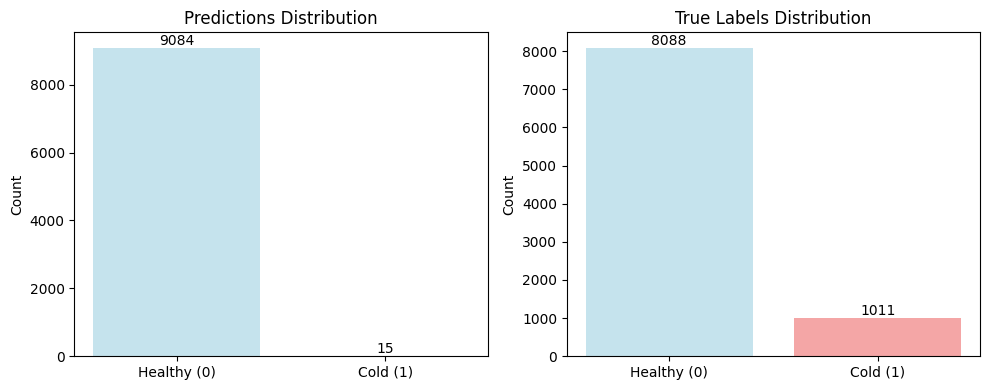


总样本数: 9099
预测为Healthy: 9084 (99.8%)
预测为Cold: 15 (0.2%)
实际Healthy: 8088 (88.9%)
实际Cold: 1011 (11.1%)


In [22]:
# 📊 简单的预测vs标签分布可视化
import matplotlib.pyplot as plt
from collections import Counter

# 统计分布
pred_counts = Counter(val_preds)
label_counts = Counter(val_labels)

print(f"预测分布: {dict(pred_counts)}")
print(f"真实标签分布: {dict(label_counts)}")

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# 预测分布
categories = ['Healthy (0)', 'Cold (1)']
pred_values = [pred_counts.get(0, 0), pred_counts.get(1, 0)]
ax1.bar(categories, pred_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax1.set_title('Predictions Distribution')
ax1.set_ylabel('Count')
for i, v in enumerate(pred_values):
    ax1.text(i, v + max(pred_values)*0.01, str(v), ha='center')

# 真实标签分布  
label_values = [label_counts.get(0, 0), label_counts.get(1, 0)]
ax2.bar(categories, label_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax2.set_title('True Labels Distribution')
ax2.set_ylabel('Count')
for i, v in enumerate(label_values):
    ax2.text(i, v + max(label_values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

# 简单统计
total = len(val_preds)
print(f"\n总样本数: {total}")
print(f"预测为Healthy: {pred_counts.get(0, 0)} ({pred_counts.get(0, 0)/total:.1%})")
print(f"预测为Cold: {pred_counts.get(1, 0)} ({pred_counts.get(1, 0)/total:.1%})")
print(f"实际Healthy: {label_counts.get(0, 0)} ({label_counts.get(0, 0)/total:.1%})")  
print(f"实际Cold: {label_counts.get(1, 0)} ({label_counts.get(1, 0)/total:.1%})")

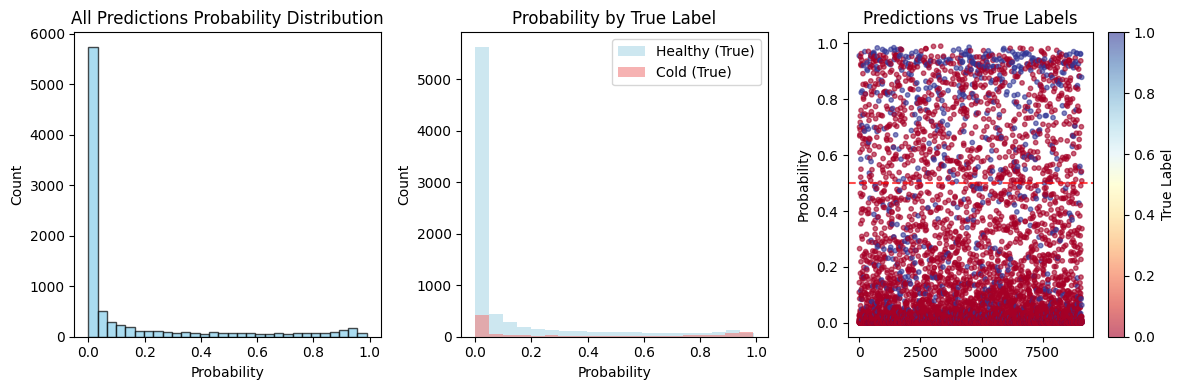


Healthy样本平均概率: 0.1242
Cold样本平均概率: 0.3512


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

val_probs = np.array(val_probs)
val_labels = np.array(val_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
healthy_probs = val_probs[val_labels == 0]
cold_probs = val_probs[val_labels == 1]

plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs, bins=20, alpha=0.6, label='Cold (True)', color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
           cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label')

plt.tight_layout()
plt.show()

print(f"\nHealthy样本平均概率: {healthy_probs.mean():.4f}")
print(f"Cold样本平均概率: {cold_probs.mean():.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

probs = []   
labels = []

model.eval()
with torch.no_grad():
    for X,y in val_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_f1 = 0.5, 0
for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best Threshold = {best_t:.2f}, Corresponding F1 = {best_f1:.3f}")


Best Threshold = 0.47, Corresponding F1 = 0.329


## Test Set

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print("\n🚀 Starting testing...")
model.eval()

clusters_txt = "./clusters_8.txt"
test_dataset = ColdDetectionDataset(
                    test_embeddings_dict, 
                    label_dict,
                    label_ratio=100
                )

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


test_preds = []
test_labels = []

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))

acc = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test F1 Score: {f1:.4f}")



🚀 Starting testing...


Testing: 100%|██████████████████████████████████████████| 9596/9596 [00:00<00:00, 38848.97samples/s]


✅ Test Accuracy: 0.8229
✅ Test F1 Score: 0.3207


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import numpy as np

# ...existing code...

# 计算UAR (Unweighted Average Recall)
uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   Accuracy: {acc:.4f}")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")



📈 PERFORMANCE METRICS:
   Accuracy: 0.8229
   F1 Score: 0.3207
   UAR (Unweighted Average Recall): 0.6349

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.8732
   Class 1 (Cold): 0.3966

✅ UAR Verification:
   sklearn UAR: 0.6349
   Manual UAR:  0.6349
   Match: ✓
